**Apple stock price prediction using LSTM**

In this script, I used Apple stock price data from 2012 to 2019.
Goal is to predict next days close price given 30 previous days'



In [1]:
# import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler 
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

In [2]:
#class for importing, manipulating, and storing data
class Data:
    df = pd.DataFrame()
    x_train_data, y_train_data = [], []
    x_test_data, y_test_data = [], []
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = []
    train_ratio = 0.8
    train_size = 0
    
    def importdf(self):
        # import Apple stock data using pandas_datareader
        self.df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17') 
    
    def display(self, rows=10):
        print(self.df.head(rows))
        
    def preprocess(self):
        #drop columns other than Date and Close
        self.df.reset_index(inplace=True)
        self.df.drop(['High', 'Low', 'Open', 'Volume', 'Adj Close'], axis=1, inplace= True)
        #turn Date column to time
        self.df["Date"]=pd.to_datetime(self.df.Date,format="%Y-%m-%d")       
        
    def plot(self, end = 120, start = 0):
        #plot prices between given dates
        plt.plot(self.df.Close[start:end])
        
    def train_test_split(self):
        #create train and test data
        self.scale()
        self.train_size = int(self.train_ratio * len(self.scaled_data))
        #for prediction use previous 30 days
        for i in range(30,self.train_size):
            self.x_train_data.append(self.scaled_data[i-30:i,0])
            self.y_train_data.append(self.scaled_data[i,0])
        for i in range(self.train_size, len(self.scaled_data)):
            self.x_test_data.append(self.scaled_data[i-30:i,0])
            self.y_test_data.append(self.scaled_data[i,0])
        #convert to numpy array
        self.x_train_data, self.y_train_data = np.array(self.x_train_data), np.array(self.y_train_data)
        self.x_test_data, self.y_test_data = np.array(self.x_test_data), np.array(self.y_test_data)
        #reshape
        self.x_train_data = np.reshape(self.x_train_data,(self.x_train_data.shape[0],self.x_train_data.shape[1],1))
        self.x_test_data = np.reshape(self.x_test_data,(self.x_test_data.shape[0], self.x_test_data.shape[1],1))
        
    def scale(self):
        #scale prices to 0,1 range
        final_dataset = self.df.Close.values
        self.scaled_data = self.scaler.fit_transform(final_dataset.reshape(-1, 1))
    
    def de_scale(self, data):
        #de-scale given data from 0-1 to original scale
        descaled = self.scaler.inverse_transform(data)
        return descaled

In [3]:
#predictor class for creation, training and usage of model
class predictor:
    model = Sequential()
    
    def create_model(self, shape, units=50):
        self.model = Sequential()
        #add a LSTM and a Dense unit      
        self.model.add(LSTM(units=units, input_shape=shape))
        self.model.add(Dense(1))
        self.model.compile(loss='mean_squared_error')
        
    def fit_lstm(self, x, y, epochs=1, batch_size=1):
        #fit to train set using loss function "mean squared error"
        self.model.fit(x, y, epochs=epochs, batch_size=batch_size, verbose=3)
    
    def predict(self, x):
        predictions = self.model.predict(x)
        return predictions
                  
    def calculate_error(self, x, y):
        predictions = self.predict(x)        
        error = mean_squared_error(y, predictions)
        return error
    
    def unit_search(self, x, y, units):
        history = list()
        for i in units:
            self.create_model(units = i, shape=(x.shape[1],1))
            self.fit_lstm(x, y)
            error = self.calculate_error(x, y)
            history.append(error)
        plt.plot(units, history)
        return units[history.index(min(history))]

In [4]:
#create data object, import data and preprocess it
data= Data()
data.importdf()
data.preprocess()
data.train_test_split()

In [5]:
data.display(5)

        Date      Close
0 2012-01-03  14.686786
1 2012-01-04  14.765714
2 2012-01-05  14.929643
3 2012-01-06  15.085714
4 2012-01-09  15.061786


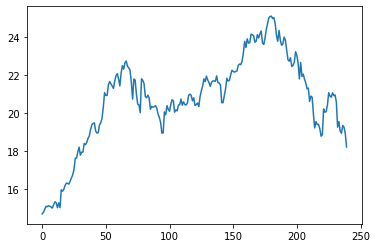

In [6]:
data.plot(240)

In [7]:
#create model object
modellstm = predictor()

60

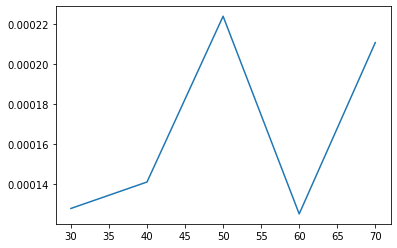

In [8]:
#Search for a optimum number of units for LSTM
modellstm.unit_search(data.x_train_data, data.y_train_data, [30, 40, 50, 60, 70])

In [9]:
#From the search result found that the units=60 is the optimum point
#Train the model using this

modellstm.create_model((data.x_train_data.shape[1],1), 60)

modellstm.fit_lstm(data.x_train_data, data.y_train_data, epochs = 3)

predictions = modellstm.predict(data.x_test_data)

descaled_pred = data.de_scale(predictions)

Epoch 1/3
Epoch 2/3
Epoch 3/3


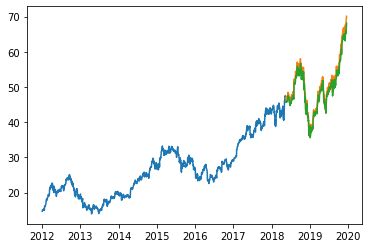

In [10]:
#Divide dataframe to test and train set as previous division
train = data.df.set_index('Date')[0: data.train_size]
test = data.df.set_index('Date')[data.train_size:]

#add predictions to test dataframe
test['Predicted'] = descaled_pred

#plot train and test close values
#For train plot real values as blue
#for test plot real values as orange and predicted values as green
plt.plot(train)
plt.plot(test[['Close', 'Predicted']])